In [271]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [272]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import tensorflow as tf
import official.nlp.modeling.layers as nlp_layers

tf.keras.utils.set_random_seed(12)
tf.config.experimental.enable_op_determinism()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# import scienceplots
# # plt.style.use('science')
# plt.style.use(['science','ieee'])
# import latex 

In [273]:
# seed = 12
# X_train = pd.read_csv('Diabetes-Data-Shift/X_train.csv')
# y_train = pd.read_csv('Diabetes-Data-Shift/y_train.csv')
# # train: (872306, 142)  val: (96923, 142)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = seed)
# # (121154, 142)
# X_test = pd.read_csv('Diabetes-Data-Shift/X_id_test.csv')
# y_test = pd.read_csv('Diabetes-Data-Shift/y_id_test.csv')
# # (209375, 142)
# X_shift = pd.read_csv('Diabetes-Data-Shift/X_ood_test.csv')
# y_shift = pd.read_csv('Diabetes-Data-Shift/y_ood_test.csv')
# OOD = pd.read_csv("heart_attack.csv")

In [274]:
seed = 12
X_train = pd.read_csv('Diabetes-Data-Shift/X_train.csv').sample(frac = 0.1, random_state=2)
y_train = pd.read_csv('Diabetes-Data-Shift/y_train.csv').sample(frac = 0.1, random_state=2)

# train: (872306, 142)  val: (96923, 142)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = seed)

# (121154, 142)
X_test = pd.read_csv('Diabetes-Data-Shift/X_id_test.csv').sample(frac = 0.1, random_state=1)
y_test = pd.read_csv('Diabetes-Data-Shift/y_id_test.csv').sample(frac = 0.1, random_state=1)

# (209375, 142)
X_shift = pd.read_csv('Diabetes-Data-Shift/X_ood_test.csv').sample(frac = 0.1, random_state=3)
y_shift = pd.read_csv('Diabetes-Data-Shift/y_ood_test.csv').sample(frac = 0.1, random_state=3)

# Added Gaussian noises on the Shift data 
shift_noises = np.random.normal(loc = 0.0, scale= 0.3, size= X_shift.shape) 
X_shift = shift_noises + X_shift.to_numpy()


ood = pd.read_csv("heart_attack.csv")
ood_noises = np.random.normal(loc = 0.0, scale= 0.7, size= ood.shape) 
OOD = ood_noises + ood.to_numpy()
# Added Gaussian noises 
# OOD1 = pd.read_csv("OOD1.csv")

# Scale all data 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)

X_val = scaler.transform(X_val.values)
X_test = scaler.transform(X_test.values)
X_shift =  scaler.transform(X_shift)

OOD = MinMaxScaler().fit_transform(OOD)

In [275]:
# class Linear(keras.layers.Layer):
#     def __init__(self, units=32, input_dim=32):
#         super().__init__()
#         self.w = self.add_weight(
#             shape=(input_dim, units),
#             initializer="random_normal",
#             trainable=True,
#         )
#         self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

#     def call(self, inputs):
#         return ops.matmul(inputs, self.w) + self.b
# x = ops.ones((2, 2))
# linear_layer = Linear(4, 2)
# y = linear_layer(x)
# print(y)

# [[ 0.085416   -0.06821361 -0.00741937 -0.03429271]
#  [ 0.085416   -0.06821361 -0.00741937 -0.03429271]]

# assert linear_layer.weights == [linear_layer.w, linear_layer.b]

In [276]:
# Best practice: deferring weight creation until the shape of the inputs is known

# class Linear(keras.layers.Layer):
#     def __init__(self, units=32):
#         super().__init__()
#         self.units = units

#     def build(self, input_shape):
#         self.w = self.add_weight(
#             shape=(input_shape[-1], self.units),
#             initializer="random_normal",
#             trainable=True,
#         )
#         self.b = self.add_weight(
#             shape=(self.units,), initializer="random_normal", trainable=True
#         )

#     def call(self, inputs):
#         return ops.matmul(inputs, self.w) + self.b

# # At instantiation, we don't know on what inputs this is going to get called
# linear_layer = Linear(32)

# # The layer's weights are created dynamically the first time the layer is called
# y = linear_layer(x)

In [277]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers = 3, num_hidden = 128,
               dropout_rate=0.1, **classifier_kwargs):
    
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [ self.make_dense_layer() for _ in range(num_layers) ]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)
 
# This method should not be called directly. 
# It is only meant to be overridden when subclassing tf.keras.Model. 
# To call a model on an input, always use the __call__() method, 
# i.e. model(inputs), which relies on the underlying call() method.
 
  def call(self, inputs, return_hidden = False):  # , return_hidden = False
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)
    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid
    if return_hidden:
      return hidden, self.classifier(hidden)
    else:
      return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [278]:
resnet_config = dict(num_classes = 2, num_layers= 3, num_hidden = 128) 

resnet_model = DeepResNet(**resnet_config)

# Weights are initialized 
resnet_model.build( (None, 142) )
resnet_model.summary()

Model: "deep_res_net_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_209 (Dense)           multiple                  18304     
                                                                 
 dense_210 (Dense)           multiple                  16512     
                                                                 
 dense_211 (Dense)           multiple                  16512     
                                                                 
 dense_212 (Dense)           multiple                  16512     
                                                                 
 dense_213 (Dense)           multiple                  258       
                                                                 
Total params: 68098 (266.01 KB)
Trainable params: 49794 (194.51 KB)
Non-trainable params: 18304 (71.50 KB)
_________________________________________________________________


In [279]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10,
                                            restore_best_weights = True)

In [280]:
fit_config = dict(batch_size = 512, epochs= 200,
            validation_data = (X_val, y_val), callbacks=[callback] )

resnet_model.compile(**train_config)

history = resnet_model.fit(X_train, y_train, **fit_config)

Epoch 1/10
171/171 [==============================] - 1s 5ms/step - loss: 0.3478 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.3170 - val_sparse_categorical_accuracy: 0.8715
Epoch 2/10
171/171 [==============================] - 1s 4ms/step - loss: 0.3163 - sparse_categorical_accuracy: 0.8733 - val_loss: 0.3118 - val_sparse_categorical_accuracy: 0.8733
Epoch 3/10
171/171 [==============================] - 1s 4ms/step - loss: 0.3115 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.3095 - val_sparse_categorical_accuracy: 0.8747
Epoch 4/10
171/171 [==============================] - 1s 4ms/step - loss: 0.3094 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.8759
Epoch 5/10
171/171 [==============================] - 1s 4ms/step - loss: 0.3076 - sparse_categorical_accuracy: 0.8752 - val_loss: 0.3080 - val_sparse_categorical_accuracy: 0.8745
Epoch 6/10
171/171 [==============================] - 1s 5ms/step - loss: 0.3058 - sparse_categorica

In [281]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()

history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()

<Axes: >

In [282]:
def resnet_model_helper(x, model = resnet_model, return_hidden = True):
    chunk_size = 100
    batches = int( (x.shape[0] / chunk_size) )
    # Units in the NN
    num_hidden = 128
    # Binary classes 
    classes = 2 
    
    hidden = np.zeros((x.shape[0], num_hidden))
    logits = np.zeros((x.shape[0], classes))
    
    for i in range(batches+1):
        if i != batches:
            s = i * chunk_size
            t = (i + 1) * chunk_size
            
            hidden_temp, sngp_logits_temp = model(x[s:t, :], return_hidden = True)
            hidden[s:t, :] = hidden_temp
            logits[s:t, :] = sngp_logits_temp
        else:
            s = i * chunk_size
            t = x.shape[0]
            hidden_temp, sngp_logits_temp = model(x[s:t, :], return_hidden = True)
            hidden[s:t, :] = hidden_temp
            logits[s:t, :] = sngp_logits_temp
            
    return hidden, logits

hidden_train_NN, NN_train_logits = resnet_model_helper(X_train )
hidden_test_NN, NN_train_logits = resnet_model_helper(X_test )
hidden_shift_NN, NN_shift_logits = resnet_model_helper(X_shift)
hidden_OOD_NN, NN_OOD_logits = resnet_model_helper(OOD)

In [283]:
# # Return the training hidden space in Standard NN 
# hidden_train_NN, NN_train_logits = resnet_model(X_train, return_hidden = True )
# hidden_test_NN, NN_train_logits = resnet_model(X_test, return_hidden = True )
# hidden_shift_NN, NN_shift_logits = resnet_model(X_shift, return_hidden = True)
# hidden_OOD_NN, NN_OOD_logits = resnet_model(OOD, return_hidden = True)

In [284]:
# Compute Stanrdard NN accuray 

In [285]:
def NN_accuracy(X, y):
    # hidden, logits = resnet_model.predict(X)
    logits = resnet_model.predict(X)
    predictions = tf.nn.softmax(logits, axis=-1)[:, 0]
    probs = np.where( predictions > 0.5 , 0, 1)
    accuracy = accuracy_score(y, probs)
    print(f'accuracy -- {accuracy}')
    return accuracy

NN_accuracy_test = NN_accuracy(X_test, y_test)
NN_accuracy_shift = NN_accuracy(X_shift, y_shift)

379/379 [==============================] - 0s 366us/step
accuracy -- 0.8733801073049938
655/655 [==============================] - 0s 412us/step
accuracy -- 0.8293533288757283


In [286]:
# Save the model
# import keras 
# resnet_model.save('Standard_model',save_format='tf')
# # Recreate the exact same model purely from the file
# resnet_model = keras.models.load_model('Standard_model')

In [287]:
# resnet_model = tf.keras.models.load_model('resnet_model.h5')
# #resnet_model = tf.keras.models.load_model('resnet_model.keras')

In [288]:
# SNGP 

In [289]:
class DeepResNetSNGP(DeepResNet):
  def __init__( self, spec_norm_bound = 0.9, **kwargs ):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  # Override the father class's method
  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier = self.spec_norm_bound)

  # Override the father class's method
  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_kernel_scale = 10.0,
        gp_cov_momentum = -1,
        **self.classifier_kwargs)
  
  def call(self, inputs, training=False, return_covmat = False, return_hidden = False): #, return_hidden=True
    # Gets logits and a covariance matrix from the GP layer.
    
    # super().cal() -- call the parents' call()
    if return_hidden:
      hidden, (logits, covmat) = super().call(inputs, return_hidden) #, return_hidden=True
    else:
      logits, covmat = super().call(inputs) #, return_hidden=True
    
    # Returns only logits during training.
    if not training and return_covmat and return_hidden: # and return_hidden
      return hidden, (logits, covmat)

    return logits

In [290]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs = None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [291]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [292]:
# This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)
  return tf.nn.softmax(logits_adjusted, axis=-1)[:,0]

In [293]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

Epoch 1/10
171/171 [==============================] - 2s 7ms/step - loss: 0.4064 - sparse_categorical_accuracy: 0.8636 - val_loss: 0.3311 - val_sparse_categorical_accuracy: 0.8748
Epoch 2/10
171/171 [==============================] - 1s 7ms/step - loss: 0.3224 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.3171 - val_sparse_categorical_accuracy: 0.8762
Epoch 3/10
171/171 [==============================] - 1s 6ms/step - loss: 0.3123 - sparse_categorical_accuracy: 0.8763 - val_loss: 0.3125 - val_sparse_categorical_accuracy: 0.8755
Epoch 4/10
171/171 [==============================] - 1s 6ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.3101 - val_sparse_categorical_accuracy: 0.8759
Epoch 5/10
171/171 [==============================] - 1s 6ms/step - loss: 0.3057 - sparse_categorical_accuracy: 0.8768 - val_loss: 0.3107 - val_sparse_categorical_accuracy: 0.8760
Epoch 6/10
171/171 [==============================] - 1s 7ms/step - loss: 0.3041 - sparse_categorica

In [294]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()

<Axes: >

In [295]:
# resnet_model.save('SNGP_model',save_format='tf')
# # Recreate the exact same model purely from the file
# resnet_model = keras.models.load_model('SNGP_model')

In [296]:
# For computation simplicity
def compute_variance(x, flag = False):
    # Huge impact on the computation efficiency
    chunk_size = 100
    batches = int( (x.shape[0] / chunk_size) )
    # Units in the NN
    num_hidden = 128
    # Binary classes 
    classes = 2 
    
    hidden = np.zeros((x.shape[0], num_hidden))
    vars = np.zeros((x.shape[0], 1))
    logits = np.zeros((x.shape[0], classes))
    # For accuray computation and need only test and shift 
    
    if flag:
        covmat = np.zeros((x.shape[0], x.shape[0]))
    for i in range(batches+1):
        if i != batches:
            s = i * chunk_size
            t = (i + 1) * chunk_size
            hidden_temp, (sngp_logits_temp, sngp_covmat_temp) = sngp_model(x[s:t, :], return_covmat = True, return_hidden = True)
            sngp_covmat_temp = tf.linalg.diag_part(sngp_covmat_temp)[:, None]
            if flag:
                covmat[s:t, :] = sngp_covmat_temp
            hidden[s:t, :] = hidden_temp
            vars[s:t, :] = sngp_covmat_temp
            logits[s:t, :] = sngp_logits_temp
        else:
            s = i * chunk_size
            t = x.shape[0]
            hidden_temp, (sngp_logits_temp, sngp_covmat_temp) = sngp_model(x[s:t, :], return_covmat = True, return_hidden = True)
            sngp_covmat_temp = tf.linalg.diag_part(sngp_covmat_temp)[:, None]
            if flag:
                covmat[s:t, :] = sngp_covmat_temp
            hidden[s:t, :] = hidden_temp
            vars[s:t, :] = sngp_covmat_temp
            logits[s:t, :] = sngp_logits_temp
    
    mean_var = np.mean(vars)
    print(f'Mean variance -- {mean_var}')
    if flag:
        return hidden, logits, vars, covmat
    else:
        return hidden, logits, vars
        
train_hidden_sngp, train_logits, train_var_sngp = compute_variance(X_train)
test_hidden_sngp, test_logits, test_var_sngp, test_covmat = compute_variance(X_test, True)
shift_hidden_sngp, shift_logits, shift_var_sngp, shift_covmat = compute_variance(X_shift, True)
OOD_hidden_sngp, OOD_logits, OOD_var_sngp = compute_variance(OOD)

train_var_sngp = train_var_sngp.ravel()
test_var_sngp = test_var_sngp.ravel()
shift_var_sngp = shift_var_sngp.ravel()
OOD_var_sngp = OOD_var_sngp.ravel()

Mean variance -- 0.007226221175046188
Mean variance -- 0.007252603708918226
Mean variance -- 0.04136062093927413
Mean variance -- 0.06496983057632574


In [297]:
sngp_probs_test = compute_posterior_mean_probability(test_logits, test_covmat)
probs_test = np.where( sngp_probs_test > 0.5 , 0, 1)
test_accuracy = accuracy_score(y_test, probs_test)
print(f'SNGP Test Accuracy --{test_accuracy}')

sngp_probs_shift = compute_posterior_mean_probability(shift_logits, shift_covmat)
probs_shift = np.where( sngp_probs_shift > 0.5 , 0, 1)
shift_accuracy = accuracy_score(y_shift, probs_shift)
print(f'SNGP Shift Accuracy --{shift_accuracy}')

SNGP Test Accuracy --0.872472141972761
SNGP Shift Accuracy --0.8284936479128857


In [298]:
# sngp_probs = compute_posterior_mean_probability(test_logits, test_covmat)
# probs = np.where( sngp_probs > 0.5 , 0, 1)
# accuracy = accuracy_score(y_test, probs)
# print(f'SNGP accuracy --{accuracy}')
# compute_accuracy(sngp_model, X_test, y_test)
# compute_accuracy(sngp_model, X_shift, y_shift)

In [299]:
# def compute_variance(x):
#     hidden, (sngp_logits, sngp_covmat) = sngp_model(x, return_covmat = True, return_hidden = True)
#     # print(sngp_covmat.shape)
#     sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
#     mean_var = np.mean(sngp_variance)
#     print(f'Mean variance -- {mean_var}')
#     # print(sngp_logits.shape)
#     # print(hidden.shape)
#     # print(sngp_variance.shape)
#     return hidden, sngp_variance

# train_hidden_sngp, train_var_sngp = compute_variance(X_train)
# test_hidden_sngp, test_var_sngp = compute_variance(X_test)
# shift_hidden_sngp, shift_var_sngp = compute_variance(X_shift)
# OOD_hidden_sngp, OOD_var_sngp = compute_variance(OOD)

# train_var_sngp = train_var_sngp.numpy().ravel()
# test_var_sngp = test_var_sngp.numpy().ravel()
# shift_var_sngp = shift_var_sngp.numpy().ravel()
# OOD_var_sngp = OOD_var_sngp.numpy().ravel()

# Mean variance -- 0.015748901292681694
# Mean variance -- 0.0159283597022295
# Mean variance -- 0.018162647262215614
# Mean variance -- 0.1431225836277008

In [300]:
# def compute_accuracy(model, X, y):
#   hidden, (sngp_logits, sngp_covmat)= model(X, return_covmat=True, return_hidden = True)
#   sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
#   probs = np.where( sngp_probs > 0.5 , 0, 1)
#   accuracy = accuracy_score(y, probs)
#   print(f'SNGP accuracy --{accuracy}')
#   return
# compute_accuracy(sngp_model, X_test, y_test)
# compute_accuracy(sngp_model, X_shift, y_shift)

In [301]:
# train_hidden = tf.constant([[1, 2], [3, 4], [5, 6]], dtype=tf.float32)
# test_hidden = tf.constant([[7, 8], [9, 10], [11, 12]], dtype=tf.float32)

# # Compute distances
# distances
# [[ 8.485281  5.656854  2.828427]
#  [11.313708  8.485281  5.656854]
#  [14.142136 11.313708  8.485281]], shape=(3, 3), dtype=float32)

# - topk_distances
# K_Distances: tf.Tensor(
# [[ 2.828427  5.656854]
#  [ 5.656854  8.485281]
#  [ 8.485281 11.313708]], shape=(3, 2), dtype=float32)

# topk_indices
# Indices: tf.Tensor(
# [[2 1]
#  [2 1]
#  [2 1]], shape=(3, 2), dtype=int32)

In [302]:
# 对于每一个测试数据，从训练数据中选取离其最近的10个点, return--> ( test_hidden.shape[0], 10)
def compute_distance(train_hidden, test_hidden, k = 10):
    distances = tf.norm(tf.expand_dims(test_hidden, axis=1) - tf.expand_dims(train_hidden, axis=0), axis=-1)
    topk_distances, topk_indices = tf.math.top_k(-distances, k=k)  # Use negative distances for smallest k distances
    return - topk_distances

In [303]:
# Compute input distance 
def distance_helper(x1, x2, k = 10):
    Dist = np.zeros((x2.shape[0], k))
    # chunk_size has a huge impact on computational efficiency
    chunk_size = 100
    batches = int( (x2.shape[0] / chunk_size) )
    for i in range(batches + 1):
        if i !=  batches:
            s = i * chunk_size
            t = (i + 1) * chunk_size
        else:
            s = i * chunk_size
            t = x2.shape[0] 
        temp = compute_distance(x1, x2[s:t, :])
        Dist[s:t, :] = temp
    return Dist

In [304]:
test_distance = distance_helper(X_train, X_test)
shift_distance = distance_helper(X_train, X_shift)
OOD_distance = distance_helper(X_train, OOD)

In [305]:
# # Compute mean along axis = 1 (rows)
test_mean_inp = tf.reduce_mean(test_distance, axis=1).numpy()
shift_mean_inp = tf.reduce_mean(shift_distance, axis=1).numpy()
OOD_mean_inp = tf.reduce_mean(OOD_distance, axis=1).numpy()

In [306]:
# Hidden distance space in SNGP

In [307]:
test_distance_sngp = distance_helper(train_hidden_sngp, test_hidden_sngp)
shift_distance_sngp = distance_helper(train_hidden_sngp, shift_hidden_sngp)
OOD_distance_sngp = distance_helper(train_hidden_sngp, OOD_hidden_sngp)

print(test_distance_sngp.shape)
print(shift_distance.shape)
print(OOD_distance_sngp.shape)

# Compute mean along axis 1 (rows)
test_mean_sngp = tf.reduce_mean(test_distance_sngp, axis=1).numpy()
shift_mean_sngp = tf.reduce_mean(shift_distance_sngp, axis=1).numpy()
OOD_mean_sngp = tf.reduce_mean(OOD_distance_sngp, axis=1).numpy()

print(test_mean_sngp.shape)
print(shift_mean_sngp.shape)
print(OOD_mean_sngp.shape)

(12115, 10)
(20938, 10)
(8763, 10)
(12115,)
(20938,)
(8763,)


In [308]:
# MC Dropout

In [309]:
num_ensemble = 10

In [310]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  hidden, logits = resnet_model(test_examples, training = True, return_hidden = True)
  return hidden, logits

In [311]:
# Monte Carlo dropout inference.
def Compute_MC(model, X, y):
  
  hidden = model(X)[0]
  dropout_logit_samples = [ model(X)[1] for _ in range(num_ensemble) ]

  dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
  vars = np.var(dropout_prob_samples, axis=0)

  dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)
  probs = np.where( dropout_probs > 0.5 , 0, 1)
  accuracy = accuracy_score(y, probs)

  #uncertainty = (dropout_probs)*(1-dropout_probs)
  print(f'Accuracy: {accuracy} -- Mean variance:{np.mean(vars)}')
  return hidden, vars

train_hidden_mc, var_mc = Compute_MC(mc_dropout_sampling, X_train, y_train)
test_hidden_mc, test_var_mc = Compute_MC(mc_dropout_sampling, X_test, y_test)
shift_hidden_mc, shift_var_mc = Compute_MC(mc_dropout_sampling, X_shift, y_shift)

print(train_hidden_mc.shape)

Accuracy: 0.8777026252436089 -- Mean variance:0.0007612775079905987
Accuracy: 0.8735451919108543 -- Mean variance:0.0007417237502522767
Accuracy: 0.8295443690896934 -- Mean variance:0.0012515378184616566
(87230, 128)


In [312]:
# OOD
def Compute_MC_OOD(model, X):
  hidden = model(X)[0] 
  dropout_logit_samples = [ model(X)[1] for _ in range(num_ensemble) ]
  
  dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
  vars = np.var(dropout_prob_samples, axis=0)
  
  print(f'Mean Variance --{np.mean(vars)}')
  
  print(hidden.shape)
  return hidden, vars

OOD_hidden_mc, OOD_var_mc = Compute_MC_OOD(mc_dropout_sampling, OOD)

Mean Variance --0.0005972444196231663
(8763, 128)


In [313]:
test_distance_mc = distance_helper(train_hidden_mc, test_hidden_mc)
shift_distance_mc = distance_helper(train_hidden_mc, shift_hidden_mc)
OOD_distance_mc = distance_helper(train_hidden_mc, OOD_hidden_mc)

print(test_distance_mc.shape)
print(shift_distance_mc.shape)
print(OOD_distance_mc.shape)

# compute mean along axis 1 (rows)
# test_distance_mc = tf.reduce_mean(test_distance_mc, axis=1).numpy()
# shift_distance_mc = tf.reduce_mean(shift_distance_mc, axis=1).numpy()
# OOD_distance_mc = tf.reduce_mean(OOD_distance_mc, axis=1).numpy()

test_mean_mc = tf.reduce_mean(test_distance_mc, axis=1).numpy()
shift_mean_mc = tf.reduce_mean(shift_distance_mc, axis=1).numpy()
OOD_mean_mc = tf.reduce_mean(OOD_distance_mc, axis=1).numpy()

print(test_mean_mc.shape)
print(shift_mean_mc.shape)
print(OOD_mean_mc.shape)

(12115, 10)
(20938, 10)
(8763, 10)
(12115,)
(20938,)
(8763,)


In [314]:
# plot_hidden_distance_hist(test_mean_mc , shift_mean_mc, OOD_mean_mc, 'Hidden_Dist_Hist_mc.pdf' )
# scatter_var_dist(test_mean_mc, shift_mean_mc, OOD_mean_mc, test_var_mc, shift_var_mc, OOD_var_mc, 'Dist_Var_MC.pdf')
# plot_variance_hist(test_var_mc, shift_var_mc, OOD_var_mc, 'MC_Var.pdf') # np.finfo(float).eps

In [315]:
# Deep ensemble training

In [316]:
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

In [317]:
def Compute_Deep(model_list, X, y):

  hidden = [model(X, return_hidden = True)[0] for model in model_list]
  hidden = tf.reduce_mean(hidden, axis = 0)

  ensemble_logit_samples = [model(X, return_hidden = True)[1] for model in model_list]
  ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
  ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

  vars = np.var(ensemble_prob_samples, axis = 0)
  probs = np.where( ensemble_probs > 0.5 , 0, 1)
  
  accuracy = accuracy_score(y, probs)

  #uncertainty = ensemble_probs * (1 - ensemble_probs)
  #uncertainty = np.mean(uncertainty)
  print(f'Accuracy: {accuracy} -- Mean Variance:{np.mean(vars)}')
  return hidden, vars

train_hidden_deep, var = Compute_Deep(resnet_ensemble, X_train, y_train)
test_hidden_deep, test_var_deep = Compute_Deep(resnet_ensemble, X_test, y_test)
shift_hidden_deep, shift_var_deep = Compute_Deep(resnet_ensemble, X_shift, y_shift)

Accuracy: 0.8787114524819443 -- Mean Variance:0.0006925482884980738
Accuracy: 0.8738753611225754 -- Mean Variance:0.0006989934481680393
Accuracy: 0.8295443690896934 -- Mean Variance:0.004138049203902483


In [318]:
def Compute_Deep_OOD(model_list, X):
  hidden = [ model(X, return_hidden = True)[0] for model in model_list]
  hidden = tf.reduce_mean(hidden, axis = 0)

  ensemble_logit_samples = [model(X, return_hidden = True)[1] for model in model_list]
  #print(ensemble_logit_samples)
  
  ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
  vars = np.var(ensemble_prob_samples, axis = 0)
  
  # predictions = [tf.nn.softmax(logits)[:,0] for logits in ensemble_logit_samples]
  #print(ensemble_prob_samples)
  # vars = np.var(predictions, axis = 0)
  print(f'Mean Variance--{np.mean(vars)}')

  return hidden, vars

OOD_hidden_deep, OOD_var_deep = Compute_Deep_OOD(resnet_ensemble, OOD)

Mean Variance--0.003253501607105136


In [319]:
test_distance_deep = distance_helper(train_hidden_deep, test_hidden_deep)
shift_distance_deep = distance_helper(train_hidden_deep, shift_hidden_deep)
OOD_distance_deep = distance_helper(train_hidden_deep, OOD_hidden_deep)

print(test_distance_deep.shape)
print(shift_distance_deep.shape)
print(OOD_distance_deep.shape)

# compute mean along axis 1 (rows)
test_mean_deep = tf.reduce_mean(test_distance_deep, axis=1).numpy()
shift_mean_deep = tf.reduce_mean(shift_distance_deep, axis=1).numpy()
OOD_mean_deep = tf.reduce_mean(OOD_distance_deep, axis=1).numpy()

print(test_mean_deep.shape)
print(shift_mean_deep.shape)
print(OOD_mean_deep.shape)

(12115, 10)
(20938, 10)
(8763, 10)
(12115,)
(20938,)
(8763,)


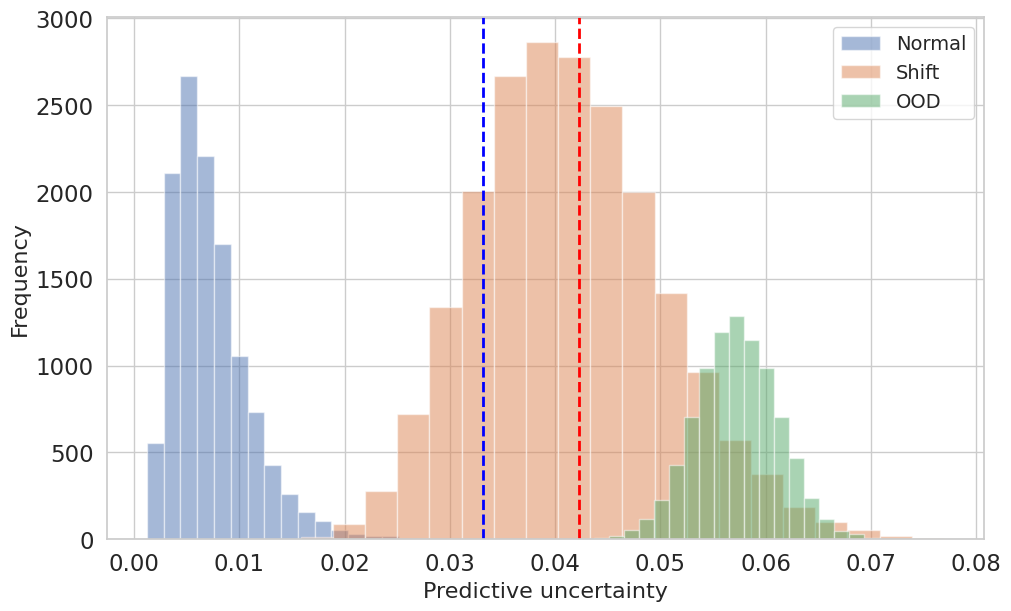

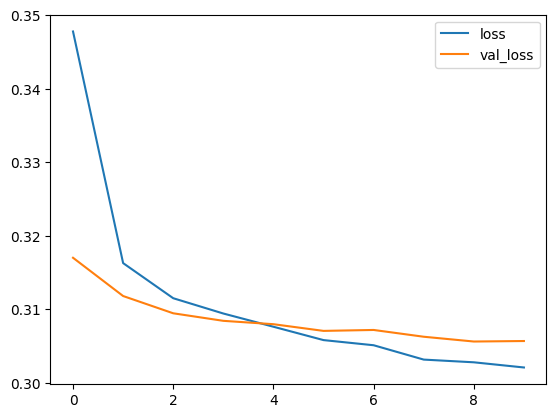

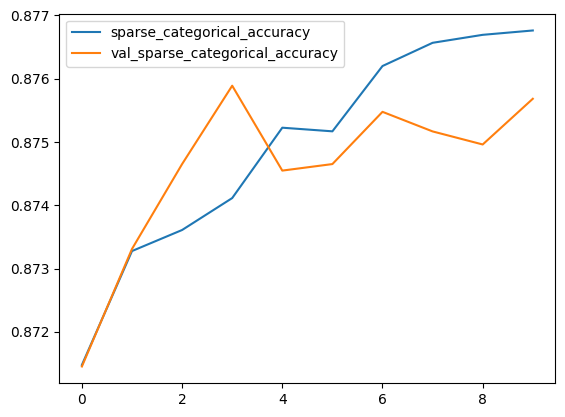

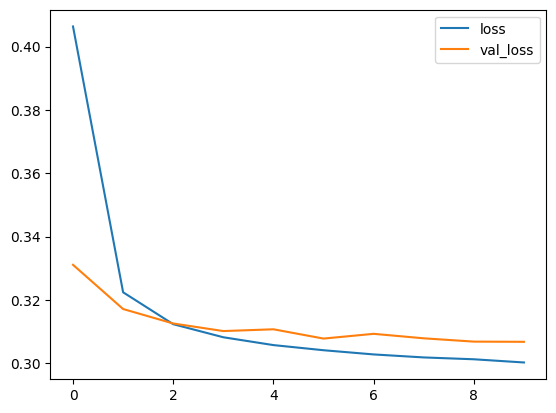

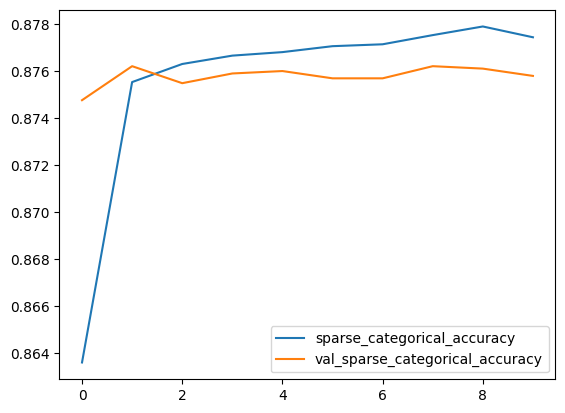

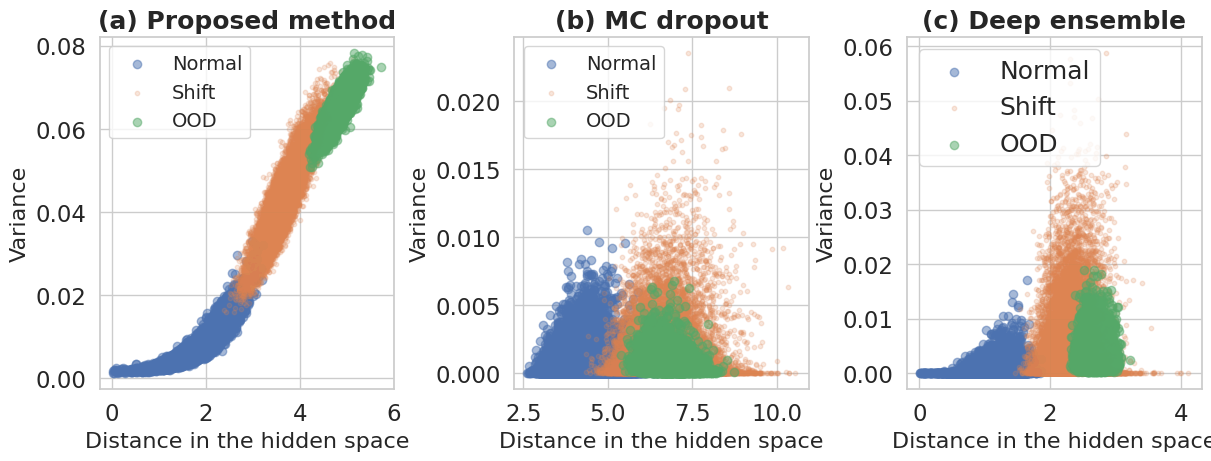

In [320]:
sns.set(style="whitegrid", font_scale = 1.5 )

fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=(12, 4.5), layout='constrained' ) # 11.69,8.27

ax1.scatter(test_mean_sngp,  test_var_sngp, alpha= 0.5, rasterized=True,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax1.scatter(shift_mean_sngp, shift_var_sngp, s = 10, alpha= 0.2, rasterized=True,label = 'Shift')
ax1.scatter(OOD_mean_sngp,   OOD_var_sngp,   alpha= 0.5, rasterized=True,label = 'OOD')


ax1.legend(fontsize=14)
ax1.set_xlabel('Distance in the hidden space', fontsize = 16)
ax1.set_ylabel('Variance', fontsize = 16)
ax1.set_title('(a) Proposed method', fontweight="bold")


ax2.scatter(test_mean_mc,  test_var_mc,  alpha= 0.5,  rasterized=True, label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax2.scatter(shift_mean_mc, shift_var_mc, s = 10, alpha= 0.2, rasterized=True, label = 'Shift')
ax2.scatter(OOD_mean_mc,   OOD_var_mc,   alpha= 0.5, rasterized=True, label = 'OOD')

ax2.legend(fontsize=14)
ax2.set_xlabel('Distance in the hidden space', fontsize = 16)
ax2.set_ylabel('Variance', fontsize = 16)
ax2.set_title('(b) MC dropout', fontweight="bold")


ax3.scatter(test_mean_deep,  test_var_deep,  alpha= 0.5, rasterized=True,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax3.scatter(shift_mean_deep, shift_var_deep, s = 10, alpha= 0.2, rasterized=True,label = 'Shift')
ax3.scatter(OOD_mean_deep,   OOD_var_deep,   alpha= 0.5, rasterized=True, label = 'OOD')
ax3.legend(fontsize=18)
ax3.set_xlabel('Distance in the hidden space', fontsize = 16)
ax3.set_ylabel('Variance', fontsize = 16)
ax3.set_title('(c) Deep ensemble', fontweight="bold")

# plt.tight_layout() 
plt.savefig('Dist-Var-comb.pdf')
plt.show()

In [321]:
# https://stackoverflow.com/questions/45897003/python-numpy-corrcoef-runtimewarning-invalid-value-encountered-in-true-divide
def cal_correlation(x1, x2):
    correlation_matrix = np.corrcoef(x1, x2)
    correlation_coefficient = correlation_matrix[0, 1]
    return correlation_coefficient

def concat_data(x1, x2, x3):
    return np.concatenate((x1, x2, x3), axis = 0)

sngp_dist = concat_data(test_mean_sngp, shift_mean_sngp, OOD_mean_sngp)
sngp_var =  concat_data(test_var_sngp,  shift_var_sngp,  OOD_var_sngp)

print('SNGP:')
print(cal_correlation(sngp_dist, sngp_var))

print(cal_correlation(test_mean_sngp,  test_var_sngp))
print(cal_correlation(shift_mean_sngp, shift_var_sngp))
print(cal_correlation(OOD_mean_sngp,   OOD_var_sngp))


mc_dist = concat_data(test_mean_mc, shift_mean_mc, OOD_mean_mc)
mc_var =  concat_data(test_var_mc,  shift_var_mc, OOD_var_mc)

print('MC dropout:')
print(cal_correlation(mc_dist, mc_var))
print(cal_correlation(test_mean_mc,  test_var_mc))
print(cal_correlation(shift_mean_mc, shift_var_mc))
print(cal_correlation(OOD_mean_mc,   OOD_var_mc))


deep_dist = concat_data(test_mean_deep, shift_mean_deep, OOD_mean_deep)
deep_var =  concat_data(test_var_deep.ravel(), shift_var_deep.ravel(), OOD_var_deep.ravel())

print('Deep ensemble:')
print(cal_correlation(deep_dist, deep_var))
print(cal_correlation(test_mean_deep,  test_var_deep))
print(cal_correlation(shift_mean_deep, shift_var_deep))
print(cal_correlation(OOD_mean_deep,   OOD_var_deep))

SNGP:
0.9825855106670174
0.8786730190077011
0.9009587975737889
0.828360952599847
MC dropout:
0.07773756100133537
0.044142011285304525
0.019356727608834865
-0.1567601974368448
Deep ensemble:
0.2850406525101719
0.21653841079371322
0.10472234960162097
0.010078955436692


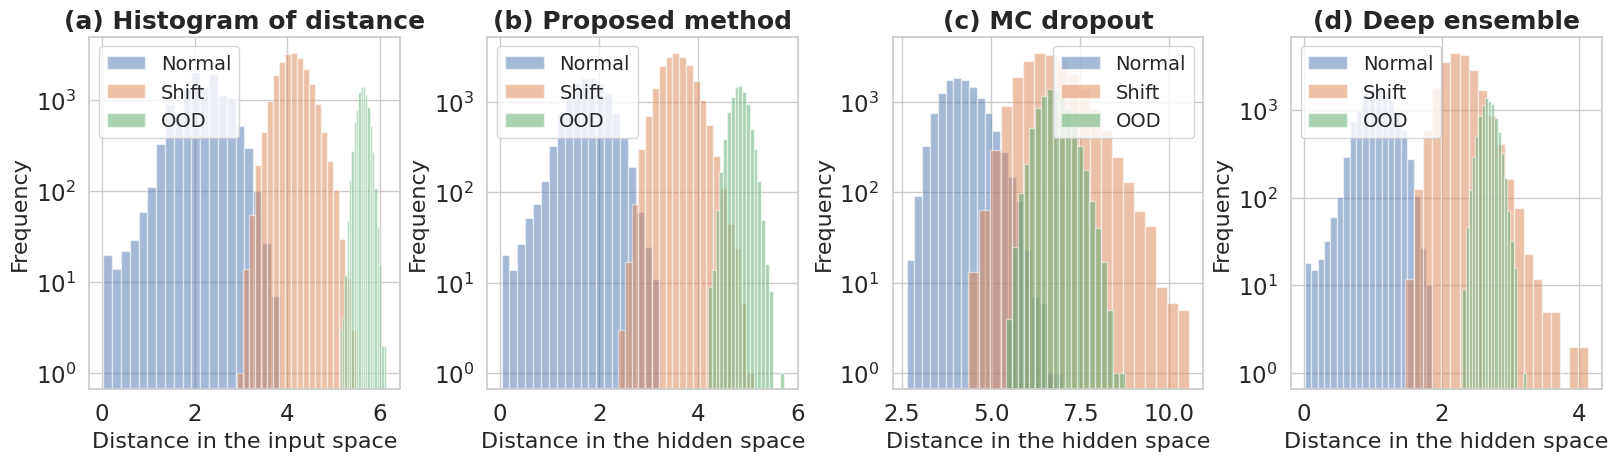

In [322]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4.5), layout='constrained' ) # 11.69,8.27

ax1.hist(test_mean_inp, bins = 20, alpha= 0.5, label = 'Normal') # density=True,
ax1.hist(shift_mean_inp, bins = 20, alpha= 0.5, label = 'Shift')
ax1.hist(OOD_mean_inp, bins = 20, alpha= 0.5, label = 'OOD')
# ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Distance in the input space', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Histogram of distance', fontweight="bold")

# ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.hist(test_mean_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax2.hist(shift_mean_sngp, bins = 20, alpha= 0.5, label = 'Shift')
ax2.hist(OOD_mean_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')
ax2.legend(fontsize=14)
ax2.set_xlabel('Distance in the hidden space', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) Proposed method', fontweight="bold")

# ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.hist(test_mean_mc,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax3.hist(shift_mean_mc, bins = 20, alpha= 0.5, label = 'Shift')
ax3.hist(OOD_mean_mc,   bins = 20, alpha= 0.5,  label = 'OOD')
ax3.legend(fontsize=14)
ax3.set_xlabel('Distance in the hidden space', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) MC dropout', fontweight="bold")

# ax4.set_xscale('log', base=10)
ax4.set_yscale('log', base=10)
ax4.hist(test_mean_deep,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax4.hist(shift_mean_deep, bins = 20, alpha= 0.5,  label = 'Shift')
ax4.hist(OOD_mean_deep,   bins = 20, alpha= 0.5, label = 'OOD')
ax4.legend(fontsize=14)
ax4.set_xlabel('Distance in the hidden space', fontsize = 16)
ax4.set_ylabel('Frequency', fontsize = 16)
ax4.set_title('(d) Deep ensemble', fontweight="bold")

#plt.tight_layout()
plt.savefig('Hidden-Distance-comb.pdf')
plt.show()

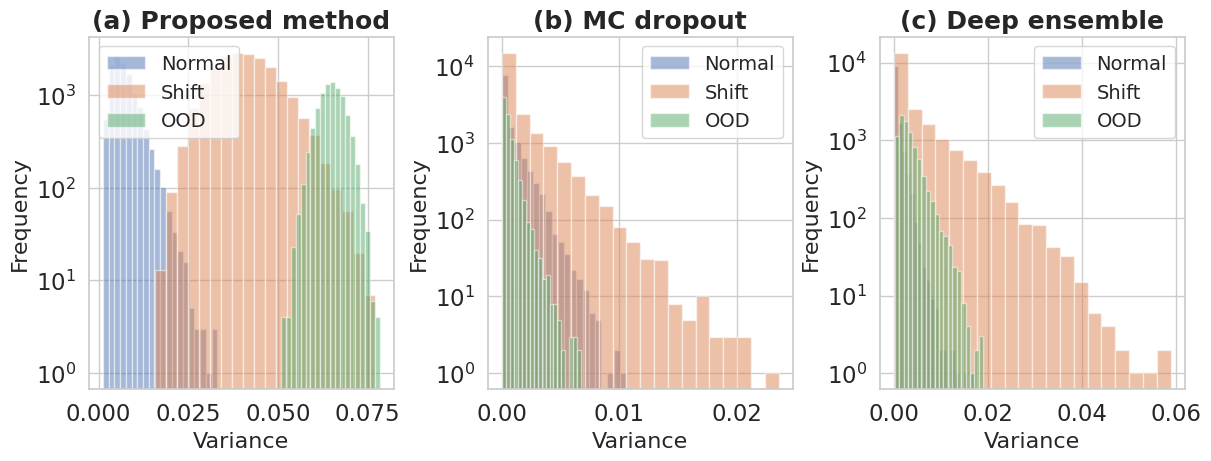

In [323]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5, label = 'Normal') 
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5, label = 'Shift')
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')

# ax1.set_xscale('log', base= 10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Variance', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Proposed method', fontweight="bold")

ax2.hist(test_var_mc,  bins = 20, alpha= 0.5,  label = 'Normal') 
ax2.hist(shift_var_mc, bins = 20, alpha= 0.5,  label = 'Shift')
ax2.hist(OOD_var_mc,   bins = 20, alpha= 0.5,  label = 'OOD')
# ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.legend(fontsize=14)
ax2.set_xlabel('Variance', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) MC dropout', fontweight="bold")

ax3.hist(test_var_deep,  bins = 20, alpha= 0.5, label = 'Normal') 
ax3.hist(shift_var_deep, bins = 20, alpha= 0.5,  label = 'Shift')
ax3.hist(OOD_var_deep,   bins = 20, alpha= 0.5,  label = 'OOD')
# ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.legend(fontsize=14)
ax3.set_xlabel('Variance', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) Deep ensemble', fontweight="bold")
#plt.tight_layout()
plt.savefig('Var-hist-comb.pdf')
plt.show()

In [324]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1) = plt.subplots(1,1, figsize=(10, 6), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') 
plt.axvline(x= test_var_sngp.max(), color = 'blue', lw = 2, ls = '--' )
print(test_var_sngp.max())
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5,  label = 'Shift')
plt.axvline(x= OOD_var_sngp.min(), color = 'red', lw = 2, ls = '--')
print(OOD_var_sngp.min())
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')

# ax1.set_xscale('log', base=10)
# ax1.set_yscale('log', base=10)

ax1.legend(fontsize=14)
ax1.set_xlabel('Predictive uncertainty', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
# ax1.set_title('Proposed method', fontweight="bold")
# plt.tight_layout()
plt.savefig('var_risk.pdf')

0.03310210257768631
0.05079527944326401
